# Grover's Oracles vs 2WQC Oracle's

Author: Bartosz Tomsia

## Introduction

Grover's quantum search algorithm [[1]("Grover")] significantly accelerates the process of searching unsorted databases, showcasing the advantages of a quantum computing over classical. However, the depth of the quantum circuits required for Grover's algorithm is a major practical challenge. As the database size grows, the circuit depth increases, limiting scalability due to error susceptibility and decoherence in current quantum hardware.

The Quantum Search Algorithm with Postselection (QSAP) aims to reduce the number of iterations required to find solutions and optimize the quantum circuit depth in Grover's algorithm in certain cases. In this notebook, we will attempt to automate the creation of the 2WQC Oracle [[4]("Czelusta")] and verify circuit complexities across different scenarios, enabling automated processing and benchmarking. By comparing the circuit depth and CNOT-gate counts of Grover's algorithm circuits with those created by QSAP, we would like to identify problem characteristics where QSAP may be more advantageous than Grover's algorithm.

### Grover's Oracle generation tools

Grover's Oracle for the algorithm can be generated from SAT problem formulas defined in the [DIMACS CNF file format](https://users.aalto.fi/~tjunttil/2021-DP-AUT/notes-sat/solving.html#the-dimacs-cnf-file-format) using the [Tweedledum](https://github.com/boschmitt/tweedledum) library. Benchmark formulas for tests can be generated with tools like [CNFgen](https://massimolauria.net/cnfgen) by Massimo Lauria. Additionally, the Qiskit [ClassicalFunction compiler](https://docs.quantum.ibm.com/api/qiskit/classicalfunction#classicalfunction-compiler) can be used for automatic circuit generation [[2]("Miranskyy")]. However, it uses the `pkrm_synth` synthesizer by default, and the most effective method is Gray synthesis [[3]("Seidel")].

Generating larger circuits for bigger SAT problems with use of [Tweedledum](https://github.com/boschmitt/tweedledum) library may require additional classical resources, so the initial benchmark test will consider smaller use cases.

---

Note: The SAT (boolean satisfiability) problem is the problem of finding an assignment of boolean variables so that the whole boolean formula becomes true, if such an assignment exists. Conjunctive Normal Form (CNF) is a conjunction of disjunctions, i.e. a set of clauses, all of which must be true. The clause is a set of literals (boolean variables), of which one (at least) must be true. The standard way of describing a CNF formula is through the DIMACS syntax.

### Sudoku problem


In his paper, Grzegorz Czelusta [[4]("Czelusta")] describes a binary Sudoku problem, which is quite simple and requires 4 qubits to create Grover's Oracle. However, for larger Sudoku problems, the number of qubits required increases rapidly with the size of the problem.

A Sudoku problem has the following constraints:

- Each cell contains exactly one number from 1 to 9.
- Each row, column and box contains each number exactly once.
- Some cells are pre-filled with given numbers (some variables are known to be true).

For example, the following Sudoku problem:

$$
\begin{array}{|c|c|c|c|}
\hline
    & 3 & 4 &   \\
\hline
  4 &   &   & 2 \\
\hline
  1 &   &   & 3 \\
\hline
    & 2 & 1 &   \\
\hline
\end{array}
$$

can be encoded into CNF using 64 variables and 168 clauses. For more details, see [Encoding Sudoku in CNF](https://users.aalto.fi/~tjunttil/2021-DP-AUT/notes-sat/solving.html#encoding-sudoku-in-cnf). This encoding would require 64 qubits and more than 24GB of RAM to generate a circuit using the [Tweedledum](https://github.com/boschmitt/tweedledum) library (verified locally). According to the Qiskit documentation for [PhaseOracle](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PhaseOracle), performance issues may arise with the default synthesizer (`pkrm_synth`) when working with 16 or more variables.

## Quantum Search Algorithm with Postselection

The method of extending the Grover's Oracle, knowing it's quantum circuit is described in supplementary material for the paper by Grzegorz Czelusta [[4]("Czelusta")]. In brief, Quantum Search Algorithm with Postselection is the following:

---

$\newcommand\identity{1\kern-0.25em\text{l}}$
**Algorithm:** Quantum Search Algorithm with Postselection

---

**Input:** Grover's Oracle $U_f$ circuit, encoding solutions $x \in B \subset S$, where $f(x) = 1$.

**Steps:**
1. Prepare initial state $|S\rangle$ in the $U_f$ register, as a superposition of Z-basis states, each representing a potential solution.
2. Add an ancillary qubit $a$: $U_f \otimes \identity_a$
3. Create $U_{\omega}$ by replacing each $Z, CZ, \ldots, C^{n-1}Z$ gate in $U_f$ with corresponding $C_{Z}X_{{U_f},a}, CC_{Z}X_{{U_f},a}, \ldots, C^{n-1}C_{Z}X_{U_f, a}$ gates, using the ancillary qubit as target.
4. Postselect the ancillary qubit to state $|1\rangle$: $(|1\rangle \langle 1|)_a U_\omega (|S\rangle|0\rangle \otimes |0 \rangle_a) = |B\rangle_{U_f} \otimes (|1\rangle \langle 0|)_a$.
5. Measure the $U_f$ register.
**Output:** The most probable states $|x\rangle$ in the $U_f$ register represent solutions where $f(x) = 1$.

---

## Install and import necessary modules

In [2]:
%%capture
!pip install qiskit qiskit-algorithms qiskit_optimization qiskit_aer pennylane pennylane-qiskit tweedledum pylatexenc

In [35]:
import os
import tempfile
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.exceptions import MissingOptionalLibraryError
from qiskit.circuit import Gate
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit_algorithms import Grover, AmplificationProblem

import pennylane as qml
from pennylane import numpy as np

## DIMACS CNF example of SAT problem

Let's take a look at example 3-SAT problem in DIMACS-CNF format from Qiskit [tutorial](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/optimization/grover.ipynb) and the one generated with [CNFgen](https://massimolauria.net/cnfgen)

In [81]:
# Example DIMACS-CNF 3-SAT
DIMACS_CNF = '''
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

# Graph automorphism formula for the complete graph of order 3
# DIMACS_CNF = '''
# p cnf 9 25
# 1 2 3 0
# 4 5 6 0
# 7 8 9 0
# 1 4 7 0
# 2 5 8 0
# 3 6 9 0
# -1 -2 0
# -1 -3 0
# -2 -3 0
# -4 -5 0
# -4 -6 0
# -5 -6 0
# -7 -8 0
# -7 -9 0
# -8 -9 0
# -1 -4 0
# -1 -7 0
# -4 -7 0
# -2 -5 0
# -2 -8 0
# -5 -8 0
# -3 -6 0
# -3 -9 0
# -6 -9 0
# '''

fp = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
fp.write(DIMACS_CNF)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except ImportError as ex:
    print(ex)
finally:
    os.remove(file_name)

In [82]:
from qiskit_algorithms import AmplificationProblem

problem = None
if oracle is not None:
    problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)

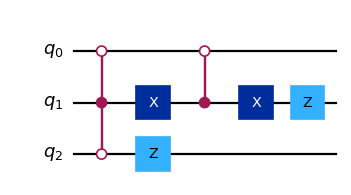

In [83]:
oracle.draw(output="mpl", scale=0.8, fold=-1)

## Oracle Extension (Qiskit)

In [84]:
def extend_oracle(circuit):
    """
    Adds an auxiliary qubit to the circuit and extends the Grover's Oracle circuit,
    by replacing z, cz, ccz gates with cx, ccx, mcx gates.

    TODO: Currently ctrl_state returns 0, should be returned the same ctrl_state that is used by original gate.

    Args:
        circuit (QuantumCircuit): The Grover's Oracle circuit.

    Returns:
        QuantumCircuit: The extended Oracle circuit.
    """
    num_qubits = circuit.num_qubits
    qr = QuantumRegister(num_qubits, 'q')
    aux = QuantumRegister(1, 'aux')
    new_circuit = QuantumCircuit(qr)
    new_circuit.add_register(aux)
    for instruction in circuit.data:
        if isinstance(instruction.operation, Gate) and instruction.operation.name == 'z':
            control = instruction.qubits[0]._index
            new_circuit.cx(control, num_qubits)
        elif isinstance(instruction.operation, Gate) and instruction.operation.name == 'cz':
            controls = [qubit._index for qubit in instruction.qubits]
            new_circuit.ccx(controls[0], controls[1], num_qubits)
        elif isinstance(instruction.operation, Gate) and instruction.operation.name == 'cz_o0':
            # TODO: Currently ctrl_state returns 0, should be '10'
            # QASM codegate cz_o0 q0,q1 { x q0; cz q0,q1; x q0; }
            # ctrl_state=instruction.operation.ctrl_state

            ctrl_state='10'
            # print(instruction.operation)
            controls = [qubit._index for qubit in instruction.qubits]
            new_circuit.ccx(controls[0], controls[1], num_qubits, ctrl_state=ctrl_state)
        elif isinstance(instruction.operation, Gate) and instruction.operation.name == 'ccz':
            controls = [qubit._index for qubit in instruction.qubits]
            new_circuit.mcx(controls, num_qubits)
        elif isinstance(instruction.operation, Gate) and instruction.operation.name == 'ccz_o0':
            # TODO: Currently ctrl_state returns 0, should be '100'
            # gate ccz q0,q1,q2 { cx q0,q2; u(0,-pi/8,-pi/8) q2; cx q1,q2; u(0,-7*pi/8,-7*pi/8) q2; cx q0,q2; u(0,-pi/8,-pi/8) q2; cx q1,q2; u(0,-7*pi/8,-7*pi/8) q2; mcphase(pi/2) q0,q1; }
            # gate ccz_o0 q0,q1,q2 { x q0; x q1; ccz q0,q1,q2; x q0; x q1; }
            # ctrl_state=instruction.operation.ctrl_state

            ctrl_state='100'
            # print(instruction.operation)
            controls = [qubit._index for qubit in instruction.qubits]
            new_circuit.mcx(controls, num_qubits, ctrl_state=ctrl_state)

        # elif isinstance(instruction.operation, Gate) and instruction.operation.name == 'c8z_o17':

            # TODO: Other use cases with gates (ControlledGate) like: c8z_o17, c8z_o33, c8z_o10, c8z_o34, c8z_o12, c8z_o20
            # gate c8z q0,q1,q2,q3,q4,q5,q6,q7,q8 { u(pi/2,0,pi) q8; cx q8,q5; p(-pi/4) q5; cx q3,q5; p(pi/4) q5; cx q8,q5; p(-pi/4) q5; cx q3,q5; u(pi/2,pi/4,-3*pi/4) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,pi/4,-pi) q4; cx q1,q4; p(-pi/4) q4; cx q0,q4; p(pi/4) q4; cx q1,q4; u(pi/2,0,3*pi/4) q4; u(0,2.191981133989078,-2.1919811339890787) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,-pi/4,3*pi/4) q5; cx q3,q5; p(pi/4) q5; cx q8,q5; p(-pi/4) q5; cx q3,q5; p(pi/4) q5; cx q8,q5; u(pi/2,pi/4,-pi) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,pi/4,-pi) q4; cx q1,q4; p(-pi/4) q4; cx q0,q4; p(pi/4) q4; cx q1,q4; u(pi/2,0,3*pi/4) q4; u(0,2.191981133989078,-2.1919811339890787) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,0,3*pi/4) q5; u(pi/4,pi/2,-pi/2) q8; cx q8,q3; p(-pi/4) q3; cx q7,q3; p(pi/4) q3; cx q8,q3; p(-pi/4) q3; cx q7,q3; u(pi/2,pi/4,-3*pi/4) q3; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,pi/4,-pi) q2; u(0,2.191981133989078,-2.1919811339890787) q3; cx q5,q2; p(-pi/4) q2; cx q4,q2; p(pi/4) q2; cx q5,q2; u(pi/2,0,3*pi/4) q2; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,-pi/4,3*pi/4) q3; cx q7,q3; p(pi/4) q3; cx q8,q3; p(-pi/4) q3; cx q7,q3; p(pi/4) q3; cx q8,q3; u(pi/2,pi/4,-pi) q3; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,pi/4,-pi) q2; u(0,2.191981133989078,-2.1919811339890787) q3; cx q5,q2; p(-pi/4) q2; cx q4,q2; p(pi/4) q2; cx q5,q2; u(pi/2,0,3*pi/4) q2; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,0,3*pi/4) q3; u(pi/4,-pi/2,pi/2) q8; cx q8,q5; p(-pi/4) q5; cx q3,q5; p(pi/4) q5; cx q8,q5; p(-pi/4) q5; cx q3,q5; u(pi/2,pi/4,-3*pi/4) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,pi/4,-pi) q4; cx q1,q4; p(-pi/4) q4; cx q0,q4; p(pi/4) q4; cx q1,q4; u(pi/2,0,3*pi/4) q4; u(0,2.191981133989078,-2.1919811339890787) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,-pi/4,3*pi/4) q5; cx q3,q5; p(pi/4) q5; cx q8,q5; p(-pi/4) q5; cx q3,q5; p(pi/4) q5; cx q8,q5; u(pi/2,pi/4,-pi) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,pi/4,-pi) q4; cx q1,q4; p(-pi/4) q4; cx q0,q4; p(pi/4) q4; cx q1,q4; u(pi/2,0,3*pi/4) q4; u(0,2.191981133989078,-2.1919811339890787) q5; cx q4,q5; p(-pi/4) q5; cx q2,q5; p(pi/4) q5; cx q4,q5; u(pi/2,0,3*pi/4) q5; u(pi/4,pi/2,-pi/2) q8; cx q8,q3; p(-pi/4) q3; cx q7,q3; p(pi/4) q3; cx q8,q3; p(-pi/4) q3; cx q7,q3; u(pi/2,pi/4,-3*pi/4) q3; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,pi/4,-pi) q2; u(0,2.191981133989078,-2.1919811339890787) q3; cx q5,q2; p(-pi/4) q2; cx q4,q2; p(pi/4) q2; cx q5,q2; u(pi/2,0,3*pi/4) q2; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,-pi/4,3*pi/4) q3; cx q7,q3; p(pi/4) q3; cx q8,q3; p(-pi/4) q3; cx q7,q3; p(pi/4) q3; cx q8,q3; u(pi/2,pi/4,-pi) q3; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,pi/4,-pi) q2; u(0,2.191981133989078,-2.1919811339890787) q3; cx q5,q2; p(-pi/4) q2; cx q4,q2; p(pi/4) q2; cx q5,q2; u(pi/2,0,3*pi/4) q2; cx q2,q3; p(-pi/4) q3; cx q6,q3; p(pi/4) q3; cx q2,q3; u(pi/2,0,3*pi/4) q3; u(pi/2,pi/4,-pi) q8; mcphase(pi/2) q0,q1,q2,q3,q4,q5,q6,q7; }
            # gate c8z_o17 q0,q1,q2,q3,q4,q5,q6,q7,q8 { x q1; x q2; x q3; x q5; x q6; x q7; c8z q0,q1,q2,q3,q4,q5,q6,q7,q8; x q1; x q2; x q3; x q5; x q6; x q7; }
            # gate c8z_o33 q0,q1,q2,q3,q4,q5,q6,q7,q8 { x q1; x q2; x q3; x q4; x q6; x q7; c8z q0,q1,q2,q3,q4,q5,q6,q7,q8; x q1; x q2; x q3; x q4; x q6; x q7; }
            # gate c8z_o10 q0,q1,q2,q3,q4,q5,q6,q7,q8 { x q0; x q2; x q4; x q5; x q6; x q7; c8z q0,q1,q2,q3,q4,q5,q6,q7,q8; x q0; x q2; x q4; x q5; x q6; x q7; }
            # gate c8z_o34 q0,q1,q2,q3,q4,q5,q6,q7,q8 { x q0; x q2; x q3; x q4; x q6; x q7; c8z q0,q1,q2,q3,q4,q5,q6,q7,q8; x q0; x q2; x q3; x q4; x q6; x q7; }
            # gate c8z_o12 q0,q1,q2,q3,q4,q5,q6,q7,q8 { x q0; x q1; x q4; x q5; x q6; x q7; c8z q0,q1,q2,q3,q4,q5,q6,q7,q8; x q0; x q1; x q4; x q5; x q6; x q7; }
            # gate c8z_o20 q0,q1,q2,q3,q4,q5,q6,q7,q8 { x q0; x q1; x q3; x q5; x q6; x q7; c8z q0,q1,q2,q3,q4,q5,q6,q7,q8; x q0; x q1; x q3; x q5; x q6; x q7; }

        else:
            new_circuit.append(instruction.operation, instruction.qubits)
    return new_circuit

Let's inspect how the process of Oracle extention is performed.

In [85]:
import qiskit.qasm2

reps = 0

if reps:
  oracle = oracle.decompose(reps=reps)

# Data of the original circuit (Oracle)
data = oracle.data

# Extended Oracle
oracle_ext = extend_oracle(oracle)

# Data of the extended Oracle circuit
data_ext = oracle_ext.data

print("Grover's Oracle:")
display(oracle.draw(fold=-1))
print()
print(qiskit.qasm2.dumps(oracle))
print()
print("Gates replacement:")
for i in range(len(data)):
    print(f"{i}: {data[i].operation.name} -> {data_ext[i].operation.name}")

print()
print("Extended Oracle (+aux):")
display(oracle_ext.draw(fold=-1))

Grover's Oracle:


q_0: ─o───────o───────────
      │ ┌───┐ │ ┌───┐┌───┐
q_1: ─■─┤ X ├─■─┤ X ├┤ Z ├
      │ ├───┤   └───┘└───┘
q_2: ─o─┤ Z ├─────────────
        └───┘


OPENQASM 2.0;
include "qelib1.inc";
gate mcphase(param0) q0,q1 { cp(pi/2) q0,q1; }
gate ccz q0,q1,q2 { cx q0,q2; u(0,-pi/8,-pi/8) q2; cx q1,q2; u(0,-7*pi/8,-7*pi/8) q2; cx q0,q2; u(0,-pi/8,-pi/8) q2; cx q1,q2; u(0,-7*pi/8,-7*pi/8) q2; mcphase(pi/2) q0,q1; }
gate ccz_o0 q0,q1,q2 { x q0; x q1; ccz q0,q1,q2; x q0; x q1; }
gate cz_o0 q0,q1 { x q0; cz q0,q1; x q0; }
qreg q[3];
ccz_o0 q[0],q[2],q[1];
z q[2];
x q[1];
cz_o0 q[0],q[1];
x q[1];
z q[1];

Gates replacement:
0: ccz_o0 -> mcx_o4
1: z -> cx
2: x -> x
3: cz_o0 -> ccx_o2
4: x -> x
5: z -> cx

Extended Oracle (+aux):


q_0: ──o─────────o────────────
       │  ┌───┐  │  ┌───┐     
q_1: ──■──┤ X ├──■──┤ X ├──■──
       │  └───┘  │  └───┘  │  
q_2: ──o────■────┼─────────┼──
     ┌─┴─┐┌─┴─┐┌─┴─┐     ┌─┴─┐
aux: ┤ X ├┤ X ├┤ X ├─────┤ X ├
     └───┘└───┘└───┘     └───┘

## Matrices of the Oracles

Qiskit uses the little-endian convention for qubit ordering, meaning the rightmost qubit in a binary representation is the least significant bit Therefore, to achieve equivalent matrices as described in the [Appendix](https://github.com/bart-q/2WQC/blob/main/2WQC_Grover_Appendix.pdf) [[4]("Czelusta")], the qubit indices must be adjusted to match the big-endian convention. Qubits reordering can be done with `reverse_bits` method.

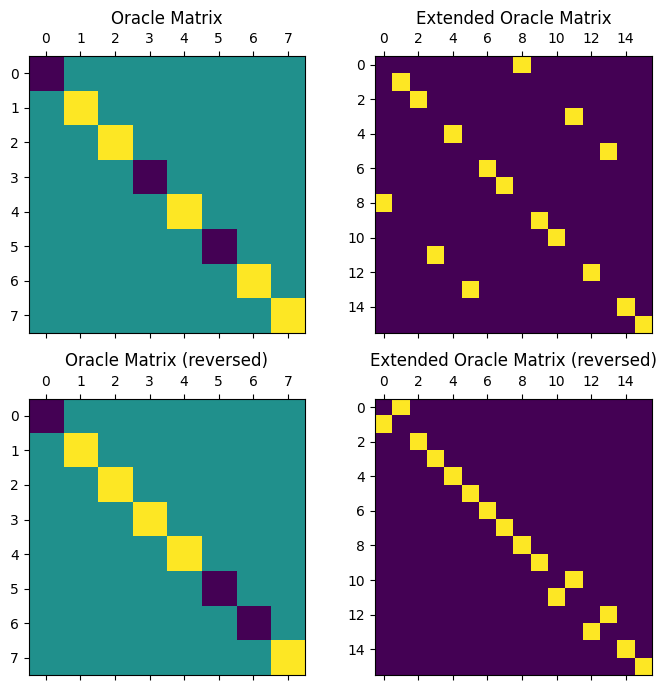

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Operator

# Define matrices
oracle_matrix = Operator(oracle).data
oracle_ext_matrix = Operator(oracle_ext).data
oracle_matrix_rev = Operator(oracle.reverse_bits()).data
oracle_ext_matrix_rev = Operator(oracle_ext.reverse_bits()).data

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))

# Plot the Oracle matrix
ax1.matshow(np.real(oracle_matrix))
ax1.set_title('Oracle Matrix')

# Plot the extended Oracle matrix
ax2.matshow(np.real(oracle_ext_matrix))
ax2.set_title('Extended Oracle Matrix')

# Plot the reversed bits Oracle matrix
ax3.matshow(np.real(oracle_matrix_rev))
ax3.set_title('Oracle Matrix (reversed)')

# Plot the reversed bits matrix of the extended Oracle
ax4.matshow(np.real(oracle_ext_matrix_rev))
ax4.set_title('Extended Oracle Matrix (reversed)')

plt.tight_layout()
plt.show()

## Circuit depths comparison

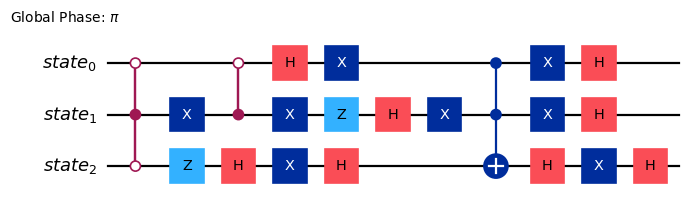

In [245]:
from qiskit.circuit.library import GroverOperator

grover_op = GroverOperator(oracle)
grover_op.decompose().draw("mpl", scale=0.8, fold=-1)

In [246]:
num_solutions = 3
optimal_num_iterations = np.floor(np.pi / (4 * np.arcsin(np.sqrt(num_solutions / 2**grover_op.num_qubits))))
optimal_num_iterations

1.0

In [247]:
problem = AmplificationProblem(oracle)
grover = Grover(sampler=Sampler(), iterations=2)
result = grover.amplify(problem)

#oracle.evaluate_bitstring("011")

Depth: 23
CX count: 10


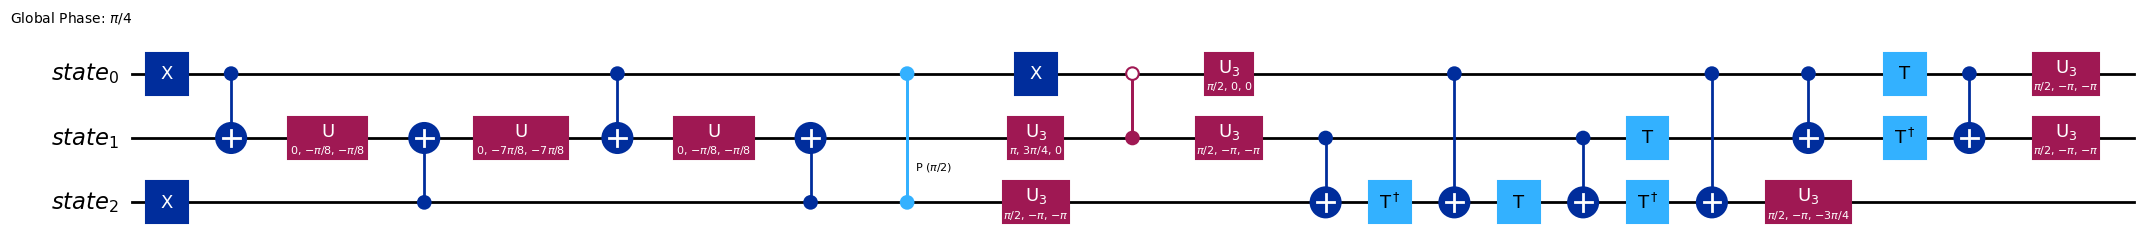

In [250]:
from qiskit import transpile

grover_operator = problem.grover_operator.decompose()

grover_operator_t = transpile(grover_operator, optimization_level=3)
print("Depth:", grover_operator_t.depth())
print("CX count:", grover_operator_t.count_ops()['cx'])
grover_operator_t.draw("mpl", fold=-1)

Depth: 41
CX count: 22


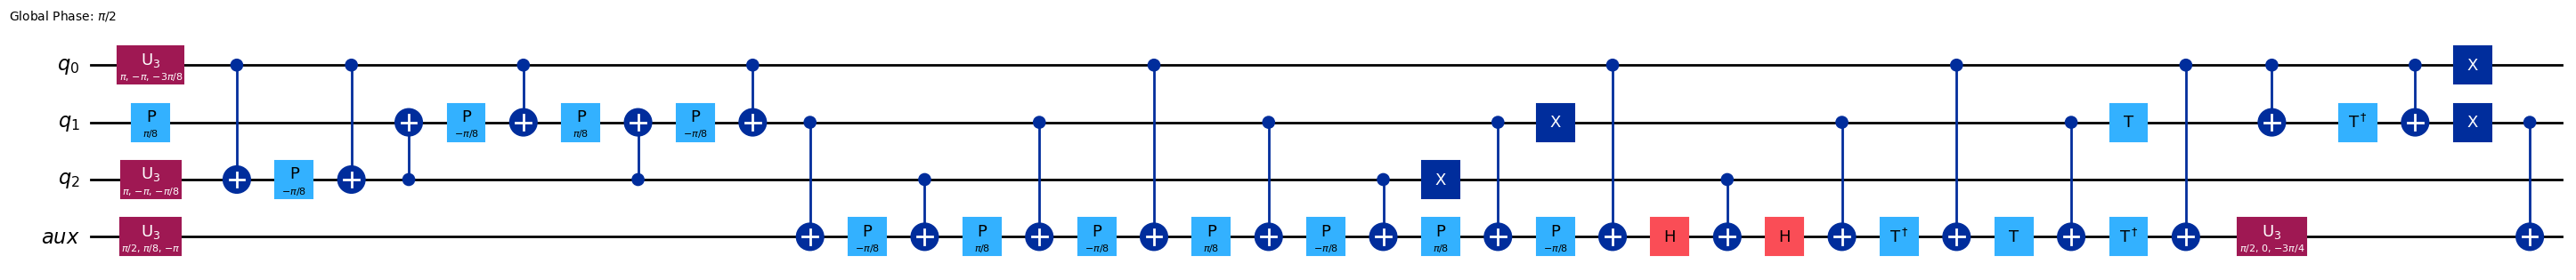

In [249]:
oracle_ext_t = transpile(oracle_ext, optimization_level=3)
print("Depth:", oracle_ext_t.depth())
print("CX count:", oracle_ext_t.count_ops()['cx'])
oracle_ext_t.draw("mpl", fold=-1)

## Controlled Z-gates implementations

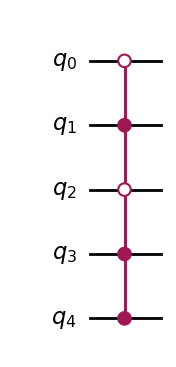

In [242]:
from qiskit.circuit.library import ZGate

num_qubits = 5
ctrl_state = '1010'
circ = QuantumCircuit(num_qubits)
c3z = ZGate().control(num_ctrl_qubits=num_qubits-1, ctrl_state=ctrl_state)
circ.append(c3z, range(num_qubits))

circ.draw('mpl')

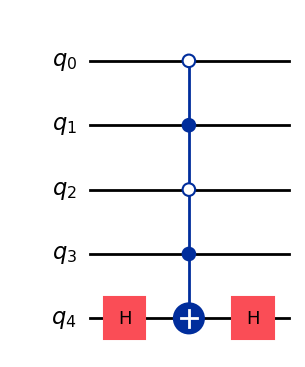

In [243]:
from qiskit.circuit.library import MCXGate

num_qubits = 5
ctrl_state = '1010'
circ = QuantumCircuit(num_qubits)
c3z = MCXGate(num_ctrl_qubits=num_qubits-1, ctrl_state=ctrl_state)
circ.h(num_qubits-1)
circ.append(c3z, range(num_qubits))
circ.h(num_qubits-1)
circ.draw('mpl')

## References

<a name='Grover'>[1]</a>: [L. K. Grover, "A fast quantum mechanical algorithm for database search" (1996)](https://arxiv.org/abs/quant-ph/9605043)

<a name='Miranskyy'>[2]</a>: [A. Miranskyy, "Using Quantum Computers to Speed Up Dynamic Testing of Software" (2022)](https://arxiv.org/abs/2209.04860)

<a name='Seidel'>[3]</a>: [R. Seidel, C. Kai-Uwe Becker, S. Bock, N. Tcholtchev, I.-D. Gheorge-Pop, M. Hauswirth, "Automatic Generation of Grover Quantum Oracles for Arbitrary Data Structures", (2021)](https://arxiv.org/abs/2110.07545)

<a name='Czelusta'>[4]</a>: [G. Czelusta, "Grover’s algorithm on two-way quantum computer" (2024)](https://github.com/gczelusta/2WQC), [B. Tomsia, Appendix](https://github.com/bart-q/2WQC/blob/main/2WQC_Grover_Appendix.pdf)